<a href="https://colab.research.google.com/github/lko9911/ACK2025_Transparent_Object_Recognition/blob/main/U%2B%2B_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U segmentation-models-pytorch

In [ ]:
# 1. 라이브러리 임포트
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# 2. 데이터셋 클래스 정의 (짝 안 맞는 파일 자동 제외)
class ClearGraspDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg'))]
        mask_files  = [f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg'))]

        # 확장자 제거 후 비교
        image_basenames = {os.path.splitext(f)[0] for f in image_files}
        mask_basenames  = {os.path.splitext(f)[0] for f in mask_files}

        # 교집합만 사용
        common_files = sorted(list(image_basenames & mask_basenames))

        # 최종 파일 목록 생성 (png 우선, 없으면 jpg)
        self.image_files = [f + ".png" if f + ".png" in image_files else f + ".jpg" for f in common_files]
        self.mask_files  = [f + ".png" if f + ".png" in mask_files else f + ".jpg" for f in common_files]

        excluded_images = image_basenames - mask_basenames
        excluded_masks  = mask_basenames - image_basenames

        print(f"✅ 최종 사용 이미지 수: {len(self.image_files)}, 마스크 수: {len(self.mask_files)}")
        if excluded_images:
            print("⚠️ 이미지에는 있는데 마스크 없는 파일:", excluded_images)
        if excluded_masks:
            print("⚠️ 마스크에는 있는데 이미지 없는 파일:", excluded_masks)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.long()

# 3. 경로 설정
test_image_dir = "/content/drive/MyDrive/Cleargrasp_Dataset/test/images"
test_mask_dir  = "/content/drive/MyDrive/Cleargrasp_Dataset/test/segmentation-masks"

# 파일 개수 확인
print("📂 원본 이미지 개수:", len([f for f in os.listdir(test_image_dir) if f.endswith(('.png','.jpg'))]))
print("📂 원본 마스크 개수:", len([f for f in os.listdir(test_mask_dir) if f.endswith(('.png','.jpg'))]))

# 4. 데이터 변환 정의
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# 5. 테스트셋 정의
test_dataset = ClearGraspDataset(test_image_dir, test_mask_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# 6. 학습된 best 모델 로드 (U-Net++ 예시)
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights=None,  # 학습된 weight 불러오므로 None
    in_channels=3,
    classes=2,
).cuda()

model.load_state_dict(torch.load("best_cleargrasp_U++.pth"))
model.eval()

# 7. 평가 함수 (Pixel Accuracy)
def calculate_pixel_accuracy(loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Testing"):
            imgs, masks = imgs.cuda(), masks.cuda()
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)  # (B, H, W)

            correct += (preds == masks).sum().item()
            total += torch.numel(masks)

    pixel_acc = correct / total
    print(f"🎯 Pixel Accuracy on Test Set: {pixel_acc * 100:.2f}%")
    return pixel_acc

# 8. 실행
calculate_pixel_accuracy(test_loader)
print(f"📂 최종 테스트셋 이미지 개수: {len(test_dataset)}")
print(f"📂 최종 테스트셋 배치 개수: {len(test_loader)} (batch_size={test_loader.batch_size})")


📂 원본 이미지 개수: 521
📂 원본 마스크 개수: 522
✅ 최종 사용 이미지 수: 521, 마스크 수: 521
⚠️ 마스크에는 있는데 이미지 없는 파일: {'star-bath-bomb-test (5)_reprocessed'}


Testing: 100%|██████████| 17/17 [01:44<00:00,  6.16s/it]

🎯 Pixel Accuracy on Test Set: 98.16%
📂 최종 테스트셋 이미지 개수: 521
📂 최종 테스트셋 배치 개수: 17 (batch_size=32)


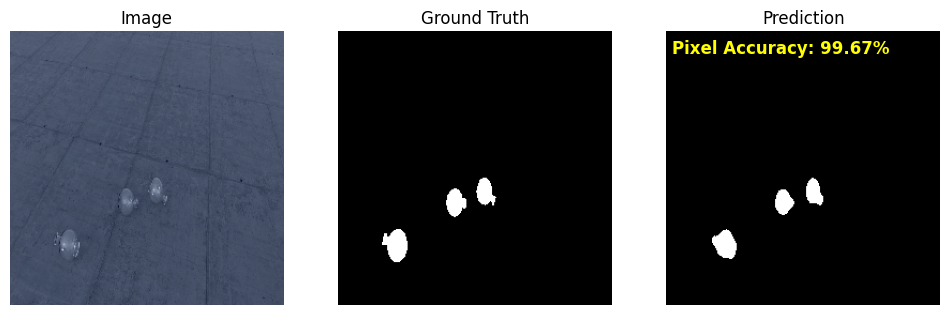

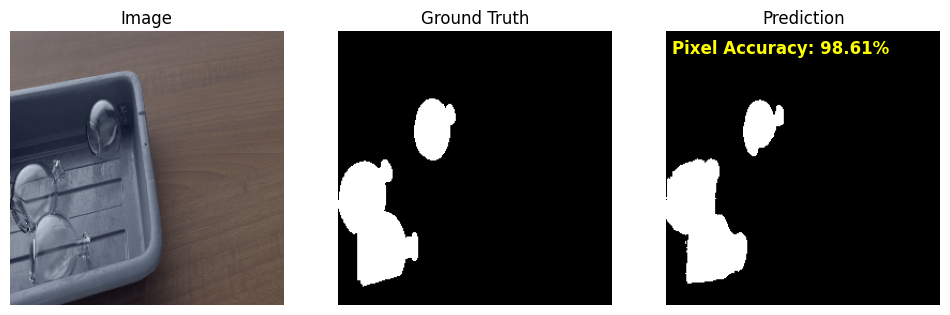

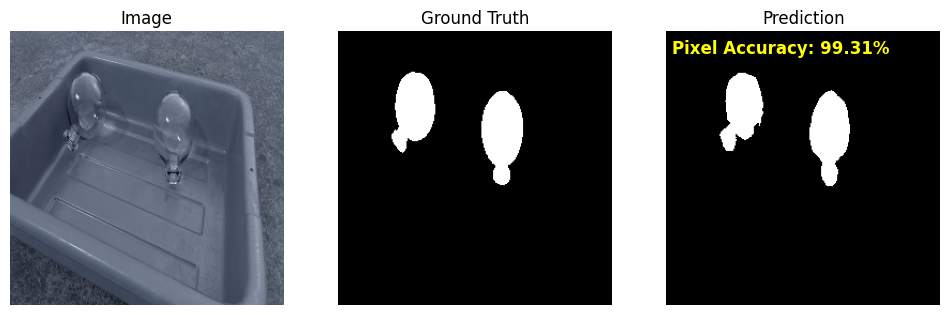

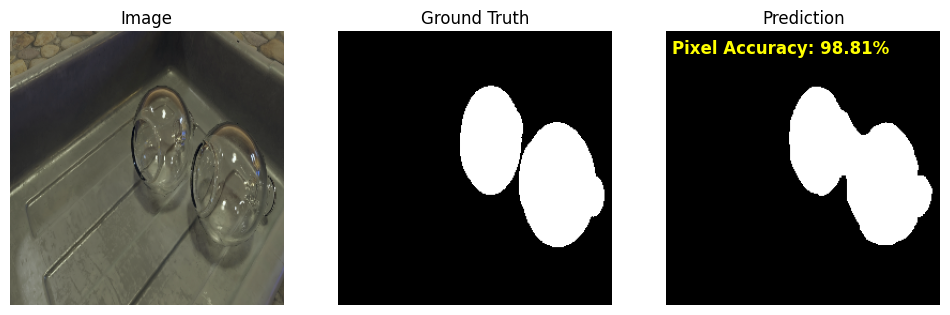

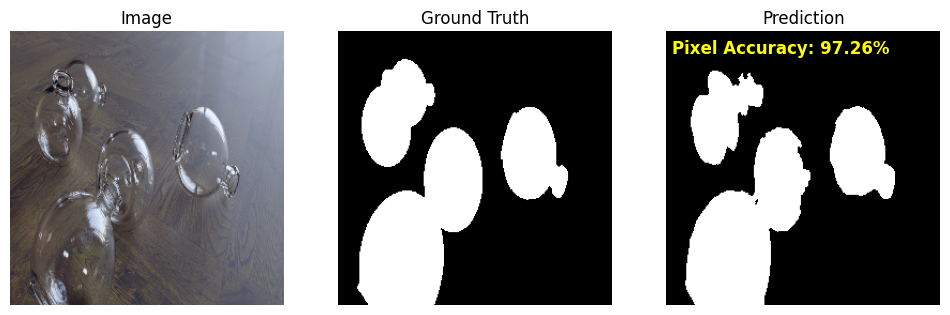

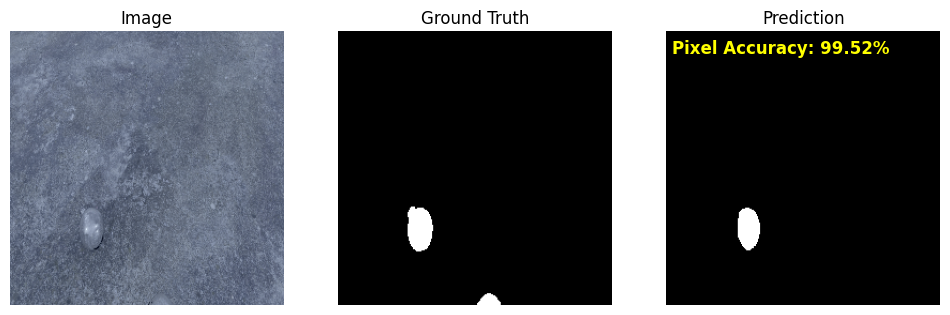

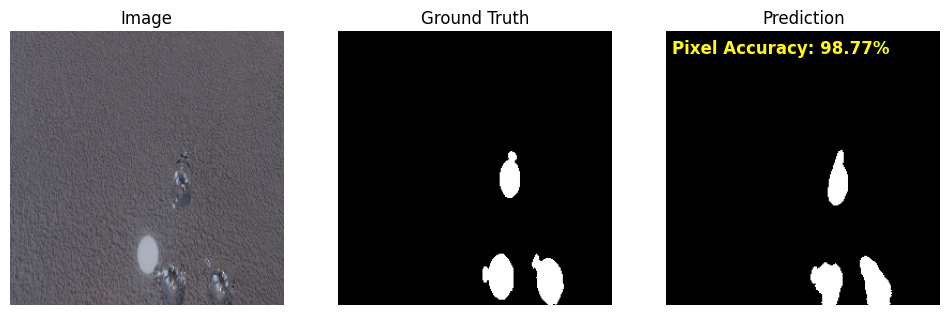

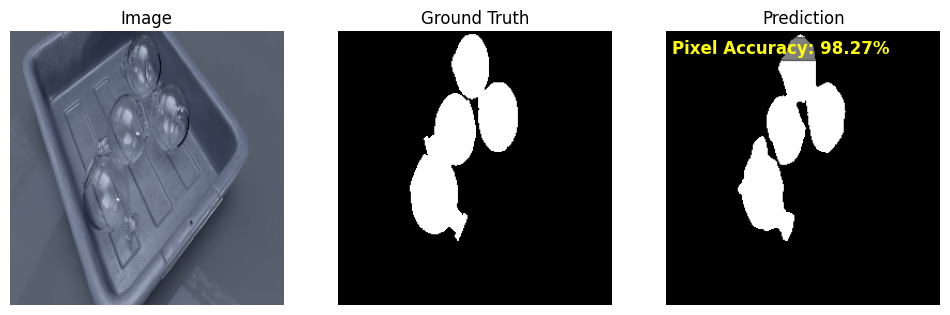

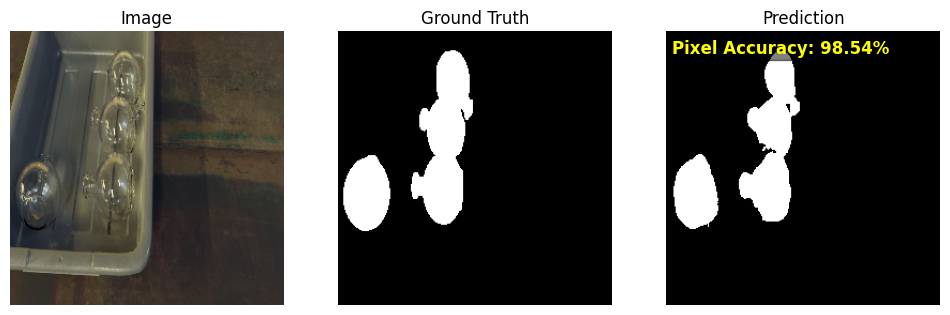

In [ ]:
def visualize_test_predictions_sequential(loader, num_batches=3, num_samples=3):
    model.eval()

    batch_iter = iter(loader)

    for batch_idx in range(num_batches):
        try:
            imgs, masks = next(batch_iter)
        except StopIteration:
            print("📌 더 이상 배치가 없습니다.")
            break

        imgs, masks = imgs.cuda(), masks.cuda()
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        imgs = imgs.cpu().permute(0, 2, 3, 1).numpy()
        masks = masks.cpu().numpy()
        preds = preds.cpu().numpy()

        num_samples_batch = min(num_samples, len(imgs))

        for i in range(num_samples_batch):
            # 이미지 0~1 범위 정규화
            img = imgs[i]
            if img.max() > 1 or img.min() < 0:
                img = (img - img.min()) / (img.max() - img.min())

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(img)
            axs[0].set_title("Image")
            axs[1].imshow(masks[i], cmap="gray")
            axs[1].set_title("Ground Truth")
            axs[2].imshow(preds[i], cmap="gray")
            axs[2].set_title("Prediction")

            acc = (preds[i] == masks[i]).sum() / masks[i].size * 100
            axs[2].text(5, 20, f"Pixel Accuracy: {acc:.2f}%", color="yellow",
                        fontsize=12, weight="bold",
                        bbox=dict(facecolor="black", alpha=0.5, pad=2))

            for ax in axs:
                ax.axis("off")
            plt.show()

visualize_test_predictions_sequential(test_loader, num_samples=3)